In [11]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb


from sklearn.model_selection import GridSearchCV


In [3]:
# 下载 nltk 的所需资源
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kerry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kerry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# 加载数据
df = pd.read_csv('netflix_reviews.csv')

In [5]:
# 检查缺失值
print(df.isnull().sum())

reviewId                    0
userName                    1
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    16239
at                          0
appVersion              16239
dtype: int64


In [6]:
# 数据清理
# 删除 `userName` 和 `content` 缺失值的行
df = df.dropna(subset=['userName', 'content'])

# 删除 `reviewCreatedVersion` 和 `appVersion` 列
df = df.drop(columns=['reviewCreatedVersion', 'appVersion'])

# 文本清理函数
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # 去除HTML标签
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 去除特殊字符，保留字母和空格
    text = text.lower()  # 转为小写
    return text

# 检查是否包含非英文字符的函数
def is_english(text):
    # 检查是否仅包含英文字符和空格
    return re.fullmatch(r'[a-zA-Z\s]*', text) is not None

# 分词和去停用词的函数
def tokenize_and_remove_stopwords(text):
    # 分词
    tokens = word_tokenize(text)
    # 去停用词
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # 重新组合成字符串
    return filtered_tokens

# 清理 `content` 列中的文本数据
df['cleaned_content'] = df['content'].apply(clean_text)

# 仅保留包含英文字符的评论
df = df[df['cleaned_content'].apply(is_english)]

# 删除 `cleaned_content` 列为空或仅含空格的评论
df = df[df['cleaned_content'].str.strip() != '']

# 应用分词和去停用词
df['tokens'] = df['cleaned_content'].apply(tokenize_and_remove_stopwords)

# 选择需要的列：'cleaned_content' 和 'thumbsUpCount'
df = df[['cleaned_content', 'thumbsUpCount']]

# 删除 'thumbsUpCount' 列中值为 NaN 的行
df = df.dropna(subset=['thumbsUpCount'])

# 由于 'thumbsUpCount' 是一个数值型数据，需要转换为分类问题
# 如果 thumbsUpCount > 0 则标记为 1 (有用)，否则为 0 (无用)
df['thumbsUpCount'] = df['thumbsUpCount'].apply(lambda x: 1 if x > 0 else 0)

# 如果需要，将清理后的数据保存到新文件中
df.to_csv('Usefulness Score Model.csv', index=False)

In [7]:
# 将文本数据转换为数值特征
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_content'])

# 目标变量
y = df['thumbsUpCount']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Overall Accuracy:  76.48%
Logistic Regression Model Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     15373
           1       0.70      0.43      0.54      7025

    accuracy                           0.76     22398
   macro avg       0.74      0.67      0.69     22398
weighted avg       0.76      0.76      0.75     22398



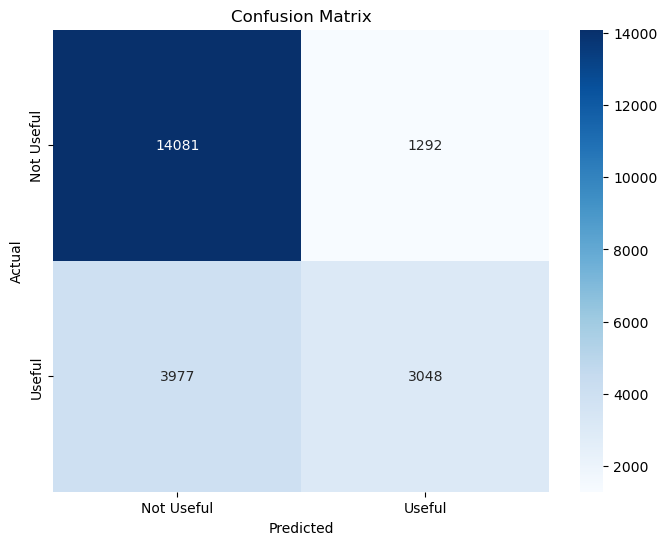

In [13]:
# 创建逻辑回归模型
model = LogisticRegression()

# 训练模型
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 输出整体准确率
overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

# 输出分类报告
print("Logistic Regression Model Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 生成有用性分数
df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]

Overall Accuracy:  75.39%
Logistic Regression Model Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     15373
           1       0.71      0.37      0.48      7025

    accuracy                           0.75     22398
   macro avg       0.74      0.65      0.66     22398
weighted avg       0.75      0.75      0.73     22398



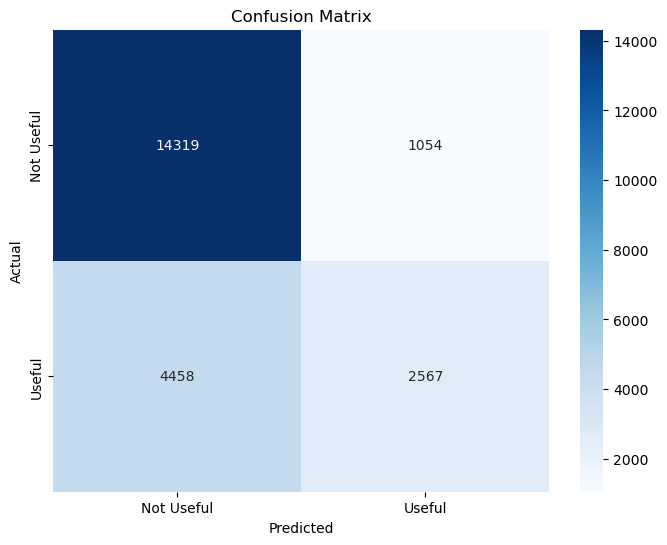

In [14]:
# 加入类别权重调整和使用随机森林模型

# 计算类别权重
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 创建随机森林模型并应用类别权重
model = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)

# 训练模型
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 输出整体准确率
overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

# 输出分类报告
print("Random Forest Model Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 生成有用性分数
df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]


Overall Accuracy:  75.39%
Logistic Regression Model Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     15373
           1       0.71      0.37      0.48      7025

    accuracy                           0.75     22398
   macro avg       0.74      0.65      0.66     22398
weighted avg       0.75      0.75      0.73     22398



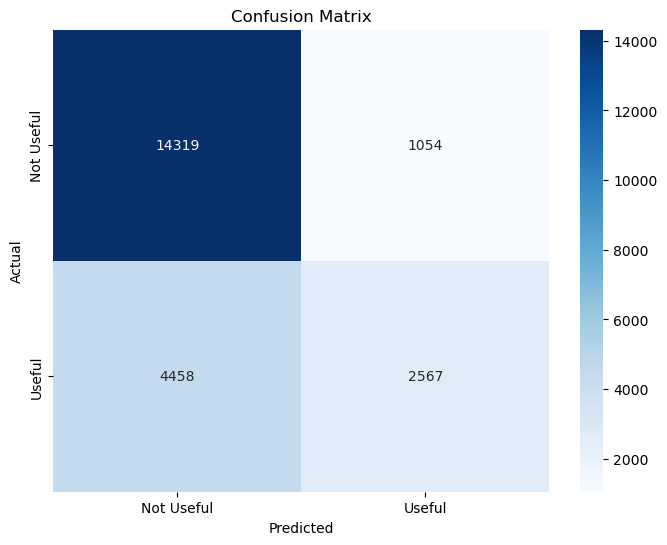

In [19]:
# 使用集成学习模型，XGBoost


# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建XGBoost模型
xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weights_dict[1]/class_weights_dict[0], random_state=42)

# 训练模型
xgb_model.fit(X_train, y_train)


# 预测
y_pred = model.predict(X_test)

# 输出整体准确率
overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))

# 输出分类报告
print("XGBoost Model Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 生成有用性分数
df['usefulness_score'] = model.predict_proba(vectorizer.transform(df['cleaned_content']))[:, 1]


In [ ]:
# 使用网格搜索优化XGBoost

# 计算类别权重
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 定义参数网格
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [1, class_weights_dict[1] / class_weights_dict[0]]
}

# 创建XGBoost模型
xgb_model = xgb.XGBClassifier(random_state=42)

# 使用GridSearchCV进行超参数优化
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)

# 使用最佳参数进行预测
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# 输出整体准确率和分类报告
overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))
print("XGBoost Model Report:")
print(classification_report(y_test, y_pred))